In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters
from scipy import stats

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from main import SimCLR
from backbones import get_backbone
from evaluation import get_dataset

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
MODEL = "MICRA-Net"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False

if MODEL == "simclr-resnet18-STED":
    transform = None
    backbone = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    transform = None
    backbone = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
print(model)
print("Model loaded")

FileNotFoundError: [Errno 2] No such file or directory: './data/ssl/baselines/micranet/result.pt'

In [5]:
dataset = get_dataset("factin-block-glugly", transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Dataset(F-actin) -- length: 295
Block - 119
GLU-GLY - 176



# Features

In [6]:
print(dataset)
out = defaultdict(list)
for x, label in tqdm(dataloader):
    features = model.backbone(x).flatten(start_dim=1)
    for key, values in label.items():
        out[key].extend(values.cpu().data.numpy().tolist())
    out["features"].extend(features.cpu().data.numpy())

Dataset(F-actin) -- length: 295
Block - 119
GLU-GLY - 176



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:26<00:00,  1.39s/it]


In [7]:
import phate 
samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])

phate_op = phate.PHATE(random_state=42)
X_transformed = phate_op.fit_transform(samples)

Calculating PHATE...
  Running PHATE on 295 observations and 256 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.23 seconds.
  Calculated graph and diffusion operator in 0.36 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.05 seconds.
Calculated PHATE in 0.50 seconds.


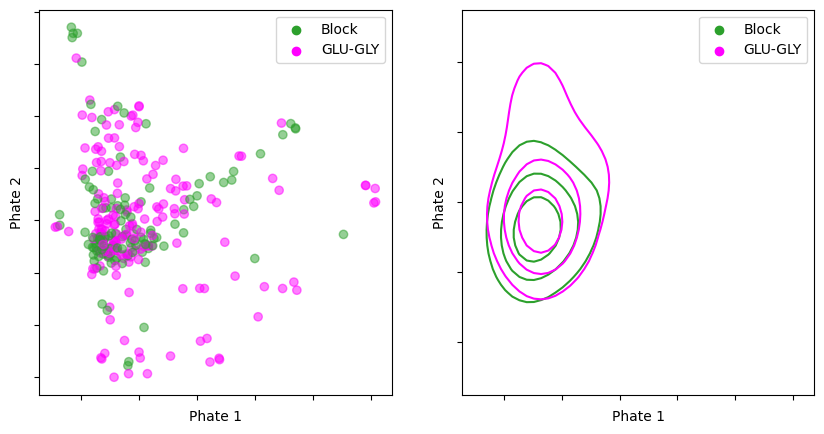

In [10]:
%matplotlib inline
fig, axes = pyplot.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(*X_transformed.T, c=labels, cmap="green-magenta", alpha=0.5)
axes[0].set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("green-magenta", len(numpy.unique(labels)))
axes[0].legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[1].get_ylim()

# fig, ax = pyplot.subplots(figsize=(5, 5))
X, Y = numpy.meshgrid(numpy.linspace(xmin, xmax), numpy.linspace(ymin, ymax))
positions = numpy.vstack([X.ravel(), Y.ravel()])
for unique in numpy.unique(labels):
    kernel = stats.gaussian_kde(X_transformed[labels == unique].T)
    Z = numpy.reshape(kernel(positions).T, X.shape)
    axes[1].contour(X, Y, Z, levels=3, colors=[cmap(unique)])
axes[1].set(
    xlim=(xmin, xmax), ylim=(ymin, ymax),
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]    
)
axes[1].legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)
pyplot.show()

<IPython.core.display.Javascript object>


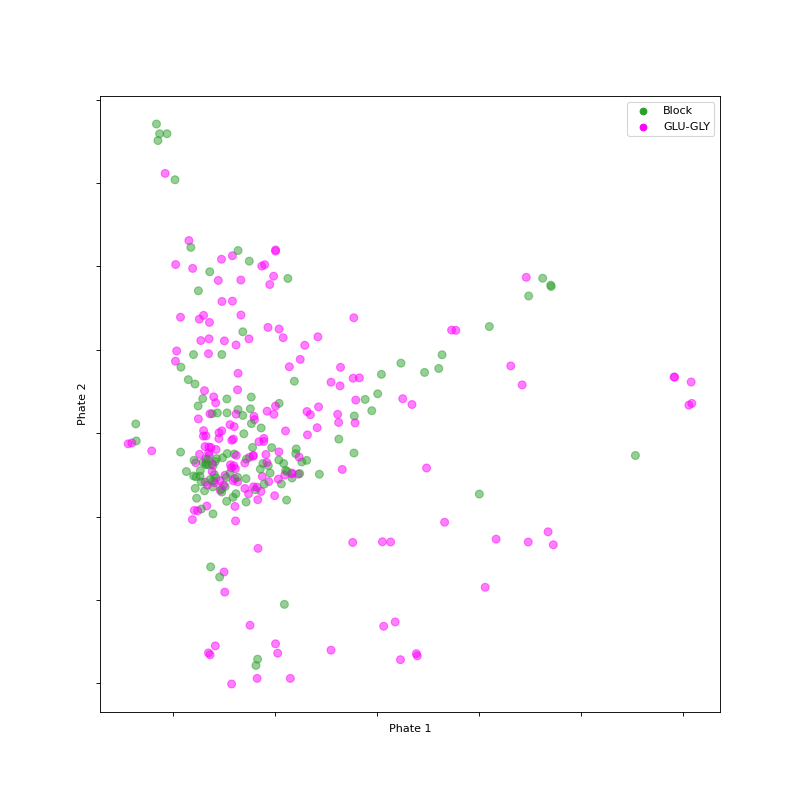

In [12]:
%matplotlib notebook

import ipywidgets
from matplotlib import colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = pyplot.subplots(figsize=(10, 10))
ax.scatter(*X_transformed.T, c=labels, cmap="green-magenta", alpha=0.5, s=50)
ax.set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("green-magenta", len(numpy.unique(labels)))
ax.legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)

# Creates the annotation box
norm = colors.Normalize(vmin=0, vmax=1)
if MODEL in ["IMAGENET1K_V1"]:
    norm = colors.Normalize(vmin=-1, vmax=1)
im = OffsetImage(dataset[0][0].numpy()[0], zoom=0.5, cmap="hot", norm=norm)
ab = AnnotationBbox(
    im, (0, 0), xybox=(75, 75), xycoords='data',
    boxcoords="offset points", frameon=False,
    arrowprops=dict(
        arrowstyle="-",
        connectionstyle="angle,angleA=0,angleB=90,rad=3")
)

# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):

    # Gets scatter points from ax
    sc = ax.collections[0]    

    contains, index = sc.contains(event)
    if contains:
        # May have multiple points in array
        index = index["ind"][0]
        # Sets the new position
        ab.xy = (X_transformed[index])

        sizes = numpy.ones(len(X_transformed)) * 50
        sizes[index] = 200
        sc.set_sizes(sizes)
        
        # Images are randomly shuffled, needs the index in dataset
        index = indices[index]
        im.set_data(dataset[index][0].numpy()[0])
        ab.set_visible(True)
    else:
        sizes = numpy.ones(len(X_transformed)) * 50
        sc.set_sizes(sizes)        

        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)
pyplot.show(block=True)